In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

PLOT = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import)

In [9]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 356027 entries, of which we have 21 features.'

# Explore the data

In [10]:
food_facts_pd.head(10)

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,manufacturing_places_tags,labels_en,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,1474103866,2016-09-17T09:17:46Z,Farine de blé noir,1kg,NaN,Ferme t'y R'nao,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
1,0000000004530,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2243.0,NaN,14,14
2,0000000004559,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,Torn & Glasser,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1941.0,NaN,0,0
3,0000000016087,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,Grizzlies,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2540.0,NaN,12,12
4,0000000016094,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1552.0,NaN,NaN,NaN
5,0000000016100,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,Unfi,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1933.0,NaN,NaN,NaN
6,0000000016117,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,Lundberg,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1490.0,NaN,NaN,NaN
7,0000000016124,1489055711,2017-03-09T10:35:11Z,Organic Muesli,NaN,NaN,Daddy's Muesli,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1833.0,NaN,7,7
8,0000000016193,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,NaN,Equal Exchange,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2406.0,NaN,NaN,NaN
9,0000000016513,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,NaN,NaN,Napa Valley Naturals,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,3586.0,NaN,NaN,NaN


## Display number of NaN entries per column

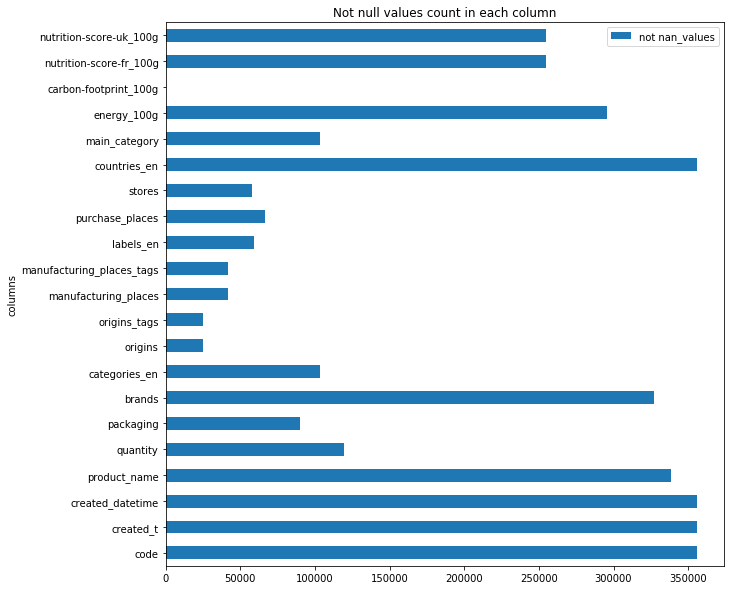

In [11]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, and a created date tag. Unfortunately, we have to drop all columns, that lack those data.

In [12]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in of our main-features
essential_columns = ['created_t', 'product_name', 'countries_en', 'categories_en', 'manufacturing_places', 'purchase_places']
food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, of which {} were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, no_rows_reduced_nan-no_rows_reduced_duplicates))
print(data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1]))

320916 entries were dropped, of which 0 were duplicates.
The dataset now comprises 35111 entries, of which we have 21 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [ ]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [ ]:
# Next lets look at the data types:

In [13]:
food_facts_pd.dtypes

code                          object
created_t                     object
created_datetime              object
product_name                  object
quantity                      object
packaging                     object
brands                        object
categories_en                 object
origins                       object
origins_tags                  object
manufacturing_places          object
manufacturing_places_tags     object
labels_en                     object
purchase_places               object
stores                        object
countries_en                  object
main_category                 object
energy_100g                  float64
carbon-footprint_100g        float64
nutrition-score-fr_100g       object
nutrition-score-uk_100g       object
dtype: object

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [ ]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [ ]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(remove_language_indicator)

The next issue we are going to tackel are redudant columns. Especially here, these are similarly named columns ending with "_en", "_tags". We are handling this, by only importing columns that end with "_en" if we have the choice.

In [ ]:
food_facts_pd

## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

In [ ]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

In [ ]:
food_facts_pd

Note :  
- purchase_places and countries_en are the same though "countries_en" is more complete
-  manufacturing_places and origins are different

"_Countries_" is a csv file modified in the "_Country__names.ipynb_" file from the source (available at https://mledoze.github.io/countries/). We need to harmonise country names (and push them to English since many entries use French and German). The columns requiring our attentions are the following :
- origins
- manufacturing_places
- countries_en

Note that there each have a respective redundant column : origins_tags, manufacturing_places_tags and purchase_places. They are gonna be filtered by a function from our _cleansing.py_ library to lead to the following respective columns:
- origins_cleaned
- manufacturing_place_cleaned
- purchase_places_cleaned



In [ ]:
food_facts_pd['origins_cleaned'] = food_facts_pd.origins
food_facts_pd['manufacturing_place_cleaned'] = food_facts_pd.manufacturing_places
food_facts_pd['purchase_places_cleaned'] = food_facts_pd.countries_en

In [ ]:
#Loading analyse file
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

The following is a test to see how complete the harmonisation is

In [ ]:
#example
copy_purchases_places = food_facts_pd[['purchase_places']].iloc[:1500, :]
#copy_purchases_places = copy_purchases_places.replace('', "Unknown", regex=True)
copy_purchases_places['Filtered'] = copy_purchases_places.purchase_places.apply(lambda x: cleanse.country_name_filter(x, countries))

In [ ]:
no_assignement = copy_purchases_places[copy_purchases_places.Filtered.apply(lambda l: l[0] == "Unknown")]
print("Percentage of entries not assigned is {0:.2f}%" .format(no_assignement.shape[0]/copy_purchases_places.shape[0]*100))

Now let's attack the Open Food Fact database

In [ ]:
#The following commands should not be run except if the analysis has to be performed again. 
#Access the result in ./data/food_facts_pd_countries_names.csv (will be saved to that)
######################################################
run = 0

In [ ]:
if( run ):
    food_facts_pd.origins_cleaned = food_facts_pd.origins_cleaned.apply(lambda x: cleanse.country_name_filter(x, countries))

In [ ]:
if( run ):
    food_facts_pd.manufacturing_place_cleaned = food_facts_pd.manufacturing_place_cleaned.apply(lambda x: cleanse.country_name_filter(x, countries))

In [ ]:
if( run ):
    food_facts_pd.purchase_places_cleaned = food_facts_pd.purchase_places_cleaned.apply(lambda x: cleanse.country_name_filter(x, countries))

In [ ]:
#Let's save these columns so that we don't have to run them again. 

#Do not run this command if you have not processed the whole dataset !
if( run ):
    food_facts_pd_countries_names = food_facts_pd[['origins_cleaned', 'manufacturing_place_cleaned', 'purchase_places_cleaned']]
    food_facts_pd_countries_names.to_csv("./data/food_facts_pd_countries_names.csv")

In [ ]:
######################################################

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'origins_cleaned')

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'manufacturing_place_cleaned')

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'purchase_places_cleaned')

### Labels tags

In [ ]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(lambda x: ",".join([labels_lookup[z] for z in x.split(',')]))

In [ ]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels_en')

### Store labels tags

In [ ]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: ",".join([stores_lookup[z] for z in x.split(',')]))

In [ ]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Food category tags

In [ ]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'categories_en')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. The goal afterward is to match Food Facts Database and Carbon Footprint database. First, let's take a look at the Carbon Footprint database.

### Loading the data

In [ ]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file,
                            delimiter=",")

In [ ]:
carbon_footprint_pd

In [ ]:
print('We have {0} ecological features for {1} products.'\
      .format(carbon_footprint_pd.shape[1], 
              carbon_footprint_pd.shape[0]))

In [ ]:
carbon_footprint_pd.describe()

In [ ]:
carbon_footprint_pd

In [ ]:
carbon_footprint_pd.shape

We are interested in the carbon footprint of each product. Because our sample is small (around 700 products) and doesn't really match with the Food Facts Database, we will take care of the categories. Thus, we will extract the categories from [Codecheck website](https://www.codecheck.info/) (Webscraper).

In [ ]:
ax = carbon_footprint_pd['CO2-Value [gram CO2/serving]'].hist(bins=50)
ax.set_xlabel('Carbon footprint')
ax.set_ylabel('Occurencies')
ax.set_title('Distribution of the carbon ')

## Concat price info

In [ ]:
prices = pd.read_csv("./web_crawler/data/prices_carbon.csv", dtype={'code':object})

In [ ]:
prices_reduced = prices[['product_name', 'price_per_100g', 'store_currency']]

In [ ]:
# food_facts_pd.code = pd.to_numeric(food_facts_pd.code, errors='coerce').fillna(0).clip_upper(sys.maxsize).astype('int')
# prices_reduced.code = prices_reduced.code.clip_upper(sys.maxsize).astype('int')

Actually we should here merge on the open food facts code, because it is guaranteed to be unique. However, it cannot be written to a text file, because pandas internally transforms it to an int, thereby removing preceding zeros, which we haven't found a workaround for yet.

Also, it is consistent in the way that we query the prices by the product name, so we would obtain the same price for products of the same name.

In [ ]:
food_facts_pd = pd.merge(food_facts_pd, prices_reduced, on='product_name', how='left')

In [ ]:
print("Product prices successfully merged: {}".format(food_facts_pd.price_per_100g.count()))

## Remove negative entries

In [ ]:
numeric_columns = food_facts_pd.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] >= 0, np.NaN)

# Write clean data frame to CSV file

In [ ]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd

    products.to_pickle("./web_crawler/products_pd.pickle")

Note : country names harmonised are available in ./data/food_facts_pd_countries_names.csv (note the additional code to go back to a list of strings). 

In [ ]:
# Apply country name filter

countries_names= pd.read_csv("./data/food_facts_pd_countries_names.csv")
countries_names.origins_cleaned = \
                        countries_names.origins_cleaned.apply(lambda l: cleanse.read(l))

countries_names.manufacturing_place_cleaned = \
                        countries_names.manufacturing_place_cleaned.apply(lambda l: cleanse.read(l))

countries_names.purchase_places_cleaned = \
                        countries_names.purchase_places_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd = food_facts_pd.drop(['origins', 'manufacturing_places', 'countries_en',\
                                   'origins_tags', 'manufacturing_places_tags','purchase_places'], \
                                    axis=1)

food_facts_pd['origins_cleaned'] = countries_names.origins_cleaned
food_facts_pd['manufacturing_place_cleaned'] = countries_names.manufacturing_place_cleaned
food_facts_pd['purchase_places_cleaned'] = countries_names.purchase_places_cleaned

In [ ]:
food_facts_pd = food_facts_pd.drop(['origins', 'manufacturing_places', 'countries_en',\
                   'origins_tags', 'manufacturing_places_tags','purchase_places'], axis=1)
food_facts_pd

In [ ]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')

In [ ]:
food_facts_pd

# Write clean data frame to CSV file

In [ ]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd[['code', 'product_name', 'stores', 'carbon-footprint_100g', 'nutrition-score-fr_100g']]
    products = products[products['carbon-footprint_100g']!=""]

    products.to_pickle("./web_crawler/data/products_pd.pickle")

In [ ]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')